# <span style = "color:black">**Introduction**

- Deep learning에서는 **각 레이어의 input의 분포가 계속해서 변화**합니다.
- 이는 네트워크의 학습에 어려움을 가져옵니다.
- 논문에서는 Batch단위의 input을 `normalization`,`shifting`,`scailing`,하여 **분포를 어느정도 일정하게 유지시킬 수 있는 방법을 제안**합니다.
- 이를 당시의 sota모델에 적용했더니 **동일한 정확도를 14배 적은 training step**으로부터 얻을 수 있었으며 **상당한 격치**를 두고 원래모델을 능가했습니다.
- 또한 동일한 방법을 적용한 앙상블 네트워크를 사용하여 **ImageNet classification에서 가장 좋은 결과**를 낼 수 있었습니다.(4.9% top5 validation error,4.8% test error)

# <span style = "color:black">**Problem setting**

- Deep Neural Network는 **학습하는 도중에 파라미터가 계속해서 변화**합니다.
- 또한 여러개의 minibatch가 input이 되는데 **각각의 minibatch가 이루는 데이터의 분포는 다릅니다..**


![internal covariate shift](./internal%20covariate%20shift.png)<br>
internal covariate shift - 출처 : [동빈나](https://www.google.com/search?q=%EB%82%98%EB%8F%99%EB%B9%88+batchnorm&oq=%EB%82%98%EB%8F%99%EB%B9%88+batchnorm&aqs=chrome..69i57.3114j0j4&sourceid=chrome&ie=UTF-8#fpstate=ive&vld=cid:93109210,vid:58fuWVu5DVU)

- 이로인해서 **각각의 hidden layer에 입력되는 input data의 분포가 학습단계에서 스텝마다 변화하는 `internal covariate shift`가 나타납니다.**(실제로 히든레이어의 output은 다차원이지만 비유적으로 1차원으로 표현한 그림임.)
- 특히 이 현상은 Deep nueral network의 특성상 **깊이 위치한 hidden layer일수록 심하게 나타납니다.**
- 이는 깊이 위치한 hidden layer일수록 **파라미터 연산이 여러번 반복되어 더 심한 변화**를 만들기 때문입니다.
- 이는 다음과 같은 두 가지의 문제점을 일으킵니다.
    1. `학습parameter`의 `converge`가 어렵습니다.
        - input의 분포가 적당히 고정된다면 그에 맞는 파라미터를 학습하여 적당한 값으로 수렴할 것입니다.
        - 그러나 internal covariance shift가 일어난다면 **계속해서 새로운 분포에 대해 다시 학습해야 하기 때문**에 수렴이 어렵습니다.
        - 비유하자면,마치 training set과 test set의 분포가 같으면 학습이 잘되고 안되면 학습이 안되는 것과 유사합니다.(저는 잘 와닿지는 않습니다.)
        
    2. `Gradient exploding` 또는 `Gradient vanishing`이 발생할 수 있습니다..
        - 분포의 변화로 인해 어떤 hidden layer에서 **시그모이드의 input이 너무 크다면 기울기가 거의 없으며 미분계수가 0에 가깝기에** 파라미터의 업데이트가 일어나지 않습니다.

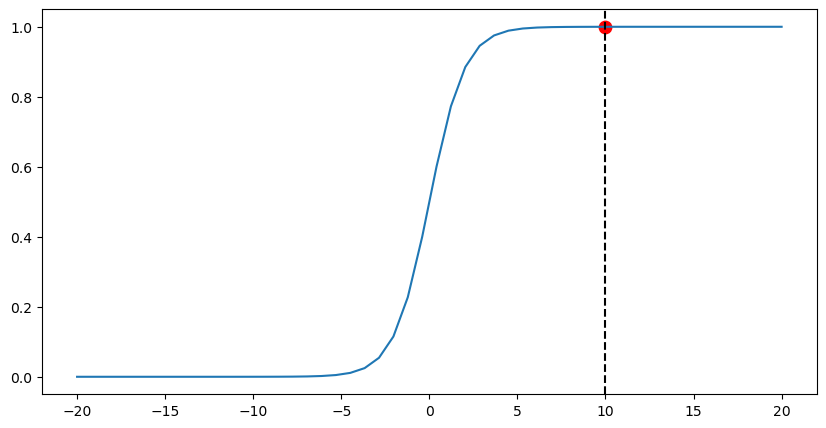

In [34]:
import matplotlib.pyplot as plt
import torch
plt.figure(figsize=(10,5))
sig = torch.nn.Sigmoid()
x = torch.linspace(-20,20,50)
z = sig(x)
point_x = torch.tensor(10)
point_z = sig(point_x)
plt.plot(x,z)
plt.scatter(point_x,point_z,s=80,color = "red")
plt.axvline(point_x,color="black",linestyle="--")

- 위와 같은 문제점 즉,`internal covariance shift`를 해결하기 위해 크게 다음과 같은 크게 2가지의 방법이 시도되어왔습니다.
    1. lower learning rate를 사용하는 방법이 연구되어 왔습니다.
    2. careful parameter initialization.(HE,Xavior)
- 그러나 각각의 방법들은 단점이 있습니다.(학습시간의 상승,초기화의 어려움)
- 해당 논문에서는 **internal covariate shift를 해결**하기 위해 **각각의 레이어에서 Batch단위로 Normalization**을 수행합니다.

# <span style = "color:black">**Method**

## <span style = "color:black">**Intuition**

![](./batchnorm.png)

BatchNormalization - 출처 : [JINSOL KIM](https://www.google.com/search?q=%EB%82%98%EB%8F%99%EB%B9%88+batchnorm&oq=%EB%82%98%EB%8F%99%EB%B9%88+batchnorm&aqs=chrome..69i57.3114j0j4&sourceid=chrome&ie=UTF-8#fpstate=ive&vld=cid:93109210,vid:58fuWVu5DVU)

- 직관적으로 `internal covariate shift`를 막기 위해 분포가 고정되게 하려면 위와 같이 각 히든레이어의 output에 normalization을 취할 수 있습니다. 이는 논문의 알고리즘에서 설명하는 방법입니다.
- 그러나 찾아본 흔히 Fully connected-layer와 activation function사이에 batchnormalization layer를 놓습니다. 이는 논문의 실험에서 사용한 방법입니다.
- 정리하자면 normalization을 적용하는 위치는 문제마다 다르지만 흔히들 위와 같이 Fully connected layer와 activation function사이에 놓는게 일반적이며 이는 비교적 자유로운 편이라 할 수 있습니다.
- 위와 같은 방법으로 **normalization만 취하게 된다면 네트워크의 표현력을 감소**시킬 수 있습니다. 시그모이드의 linear regime에 값들이 대다수 위치하기 때문입니다.(뉴럴넷은 선형+비선형 변환을 통해서 높은 표현력을 지닙니다.단순히 normalization만 취하면 비선형함수의 역할이 감소하게 됩니다.)

![figure3 - DNN with learnable parameter](./learnable%20parameters.png)

- 따라서 normalization된 값을 적절하게 `shifting`,`scailing`하도록 각 뉴런에 붙는 `learnable parameter` $\gamma,\beta$를 추가합니다.

> 정리하자면 BatchNormalization은 **Batch단위로 `normalization`을 통해 `internal covariate shift`를 막고 동시에 `learnable parameter`로 `shifting`,`scailing`함으로서 nonlinearity를 유지하여 gradient vanishing(exploding),학습의 어려움,표현력의 감소와 같은 문제를 해결**했다고 할 수 있습니다.

## <span style = "color:black">**Implementation**

### <span style = "color:black">**Training**

![Figure4 - BN Algorithm](./BN%20algorithm.PNG)

**notation**

- 논문의 알고리즘 부분에서는 Batchnormalization은 activation function바로 다음에 위치하는 것을 기준으로 설명합니다.
- $\mathcal{B} = \{x_{1...m}\}$는 크기가 m인 batch를 입력했을때 임의의 노드에서 출력된 m개의 scalar값이다.(activation function을 통과한 후이다.)m개의 output입니다.
- $\mu_{\mathcal{B}}$,$\sigma^2_{\mathcal{B}}$는 각각 $\mathcal{B}$의 평균,분산을 의미합니다.
- $\hat{x_i}$는 $\mathcal{B}$에 속하는 임의의 원소 $x_i$에 `normalization`한 값입니다.
- 여기서 $\epsilon$은 매우작은 값을 의미하며 분산이 0일때의 연산이 불안정해지는 것을 막습니다.
- $y_i$는 `learnable parameter`인 $\gamma,\beta$에 대한 값이며 $\text{BN}_{\gamma,\beta}(x_i)$를 계산한 결과입니다.

**explanation**
- 먼저 크키가m인 batch에 대해서 어떤 노드에서 m개의 스칼라값인 $\mathcal{B}$가 출력됩니다.
- $\mathcal{B}$의 평균,분산을 계산합니다.
- $\forall x_i \in \mathcal{B}$에 대하여 normalization을 취하고 learnable parameter인 $\gamma,\beta$를 곱합니다.

**학습된 $\gamma$,$\beta$의 예시**<br>
**Normalization연산이 필요없다고 학습한 경우,nonlinearity를 유지하는 것이 좋은 경우,identity를 유지하는게 좋은 경우** <br>
$$\gamma \approx \sqrt{var[x]},\beta \approx \mathbb{E}[x] \rightarrow \hat{x_i}\approx x_i  $$
**Normalization연산이 필요하다고 학습한 경우,linearity를 가지는 것이 경우,identity를 버리는게 좋은 경우** <br>
$$\gamma \approx 1,\beta \approx 0 \rightarrow \hat{x_i} \approx \frac{x_i-\mu_\mathcal{B}}{\sqrt{\sigma_\mathcal{B}^2-\epsilon}}$$

### <span style = "color:black">**Test or Inference**

- training에서는 minibatch단위로 평균,분산을 구하여 normalization할 수 있지만 test에서는 이와는 다르게 **minibatch단위로 data가 입력되지 않을뿐더러** 또한 **입력되는 데이터가 한개여도 올바르게 예측해야 원합니다.** 
- 따라서 이때에는 **training에서 각각의 배치들로부터 얻은 평균들과 분산들을 저장**해놓고 **test에서는 이 값들로 다시 평균을 취하여(평균들의 평균) normalization**을 취합니다. 
- 이때 단순한 평균을 취하는 것이 아니라 어느정도 **학습된 네트워크에서 얻어진 minibatch들의 데이터를 더 많이 고려**하기 위해서 **`movingaverage`나 `exponentialaverage`를 사용**합니다. 
- movingaverage는 학습단계에서 얻어진 값(평균,분산)의 일부를 직접 지정하여 평균을 구하고 exponentialaverage는 어느정도 안정된 상태의 값(나중값)들에 가중치를 부여하여 평균,분산을 구하는 방법입니다.

\begin{aligned}
&\hat{x} = \frac{x - \mathbb{E}[x]}{\text{Var}[x] + \epsilon}\\
&y = \frac{\gamma}{\sqrt{\text{var}[x] + \epsilon}}\cdot x + (\beta - \frac{\gamma\mathbb{E}[x]}{\sqrt{\text{Var}[x] + \epsilon}})\\
&\text{where }E[x] = E_\mathcal{B}[\mu_\mathcal{B}],\text{Var}[x] = \frac{m}{m-1}E_\mathcal{B}[\sigma_\mathcal{B}^2]
\end{aligned}

- $\frac{m}{m-1}$은 unbiased estimate를 위하여 곱해진 값이며 $E_{\mathcal{B}}$는 moving average 또는 exponential average를 의미합니다. 
- test에서의 normalization은 단순한 linear transform으로 취급할 수 있는데 이는 training이 끝난 후 사전에 이 값을 계산하여 단순히 곱하고 더하는 것으로 계산할 수 있기 때문입니다.

## <span style = "color:black">**Experiments**

![](./pp-figure1.png)<br>
Figure5 - Mnist experiment

- (a)는 BN을 사용한 네트워크와 사용하지 않은 네트워크를 비교, (b,c)는 각 네트워크의 hiddenlayer의 sigmoid의 input 3개를 비교한 것
- 네트워크는 각각 100개의 activation을 가지며 3개의 hiddenlayer가 존재
- (a)를 보면BN을 사용한 네트워크가 훨씬 빠른속도로 수렴하고 있음을 알 수 있음
- (b,c)를 보면 BN을 사용한 네트워크에서 값이 훨씬 안정적임을 알 수 있음(`internal covariate shift`가 적음)

![](./pp-figure2.png)

- BN사용한 모델이 좋았다~

# <span style = "color:black">**Reference**
- [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167)
- [Jin Sol KIM](https://gaussian37.github.io/dl-concept-batchnorm/)
- [동빈나](https://www.google.com/search?q=%EB%82%98%EB%8F%99%EB%B9%88+batchnorm&oq=%EB%82%98%EB%8F%99%EB%B9%88+batchnorm&aqs=chrome..69i57.3114j0j4&sourceid=chrome&ie=UTF-8#fpstate=ive&vld=cid:93109210,vid:58fuWVu5DVU)